# **Install**

In [ ]:
!pip install flair sklearn-crfsuite pytorch-crf seqeval --quiet

In [ ]:
!pip install --upgrade flair

In [ ]:
!pip install flair[word-embeddings]

# **Import Dataset and Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_path = "/kaggle/input/nerskill/NERSkill.Id.txt"
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence #", "Word", "Tag"], skiprows=1)

df["Sentence #"] = df["Sentence #"].ffill()

sentences = (
    df.groupby("Sentence #", group_keys=False)
    .apply(lambda s: list(zip(s["Word"], s["Tag"])))
    .tolist()
)

train_sentences, temp_sentences = train_test_split(sentences, test_size=0.3, random_state=42)
val_sentences, test_sentences = train_test_split(temp_sentences, test_size=1/3, random_state=42)

<ipython-input-11-f32273d4666c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda s: list(zip(s["Word"], s["Tag"])))


# **CRF**

In [ ]:
# Extract feature for every word in sentences
def word_features(sent, i):
    """Mengekstrak fitur untuk setiap kata dalam kalimat."""
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    # contextual feature
    if i > 0:
        prev_word = sent[i-1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        next_word = sent[i+1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Conversion all data into feature format and label
def sent_to_features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent):
    return [label for _, label in sent]

In [ ]:
X_train, y_train = [sent_to_features(s) for s in train_sentences], [sent_to_labels(s) for s in train_sentences]
X_val, y_val = [sent_to_features(s) for s in val_sentences], [sent_to_labels(s) for s in val_sentences]
X_test, y_test = [sent_to_features(s) for s in test_sentences], [sent_to_labels(s) for s in test_sentences]

In [ ]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from itertools import product

In [ ]:
c1_values = [0.01, 0.1, 1, 10]
c2_values = [0.01, 0.1, 1, 10]
max_iterations_values = [50, 100, 200]

results = []

for c1, c2, max_iter in product(c1_values, c2_values, max_iterations_values):
    print(f"Training CRF with c1={c1}, c2={c2}, max_iterations={max_iter}")

    crf = CRF(
        algorithm='lbfgs',
        c1=c1,
        c2=c2,
        max_iterations=max_iter,
        all_possible_transitions=True
    )

    crf.fit(X_train, y_train)
    y_val_pred = crf.predict(X_val)

    val_f1 = flat_f1_score(y_val, y_val_pred, average='weighted')

    results.append({
        'c1': c1,
        'c2': c2,
        'max_iterations': max_iter,
        'val_f1': val_f1
    })

results_df = pd.DataFrame(results)

print("\nHasil Hyperparameter Tuning (Diurutkan dari validasi f1-score terbaik):")
print(results_df.sort_values(by="val_f1", ascending=False))

Training CRF with c1=0.01, c2=0.01, max_iterations=50
Training CRF with c1=0.01, c2=0.01, max_iterations=100
Training CRF with c1=0.01, c2=0.01, max_iterations=200
Training CRF with c1=0.01, c2=0.1, max_iterations=50
Training CRF with c1=0.01, c2=0.1, max_iterations=100
Training CRF with c1=0.01, c2=0.1, max_iterations=200
Training CRF with c1=0.01, c2=1, max_iterations=50
Training CRF with c1=0.01, c2=1, max_iterations=100
Training CRF with c1=0.01, c2=1, max_iterations=200
Training CRF with c1=0.01, c2=10, max_iterations=50
Training CRF with c1=0.01, c2=10, max_iterations=100
Training CRF with c1=0.01, c2=10, max_iterations=200
Training CRF with c1=0.1, c2=0.01, max_iterations=50
Training CRF with c1=0.1, c2=0.01, max_iterations=100
Training CRF with c1=0.1, c2=0.01, max_iterations=200
Training CRF with c1=0.1, c2=0.1, max_iterations=50
Training CRF with c1=0.1, c2=0.1, max_iterations=100
Training CRF with c1=0.1, c2=0.1, max_iterations=200
Training CRF with c1=0.1, c2=1, max_iterati

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

y_test_pred = crf.predict(X_test)

In [ ]:
from seqeval.metrics import classification_report as entity_classification_report

# Token-level report (from sklearn_crfsuite)
print("=== Token-Level Report ===")
token_report = flat_classification_report(y_test, y_test_pred)
print(token_report)

# Entity-level report (from seqeval)
print("\n=== Entity-Level Report ===")
entity_report = entity_classification_report(y_test, y_test_pred)
print(entity_report)

=== Token-Level Report ===
              precision    recall  f1-score   support

    B-HSkill       0.73      0.62      0.67      1751
    B-SSkill       0.81      0.81      0.81      1116
      B-Tech       0.88      0.85      0.86      1538
    I-HSkill       0.67      0.61      0.64      1159
    I-SSkill       0.72      0.64      0.67       377
      I-Tech       0.71      0.78      0.75       394
           O       0.96      0.97      0.96     34697

    accuracy                           0.93     41032
   macro avg       0.78      0.75      0.77     41032
weighted avg       0.93      0.93      0.93     41032


=== Entity-Level Report ===
              precision    recall  f1-score   support

      HSkill       0.69      0.58      0.63      1763
      SSkill       0.78      0.77      0.78      1132
        Tech       0.84      0.81      0.83      1540

   micro avg       0.77      0.71      0.74      4435
   macro avg       0.77      0.72      0.75      4435
weighted avg       0.

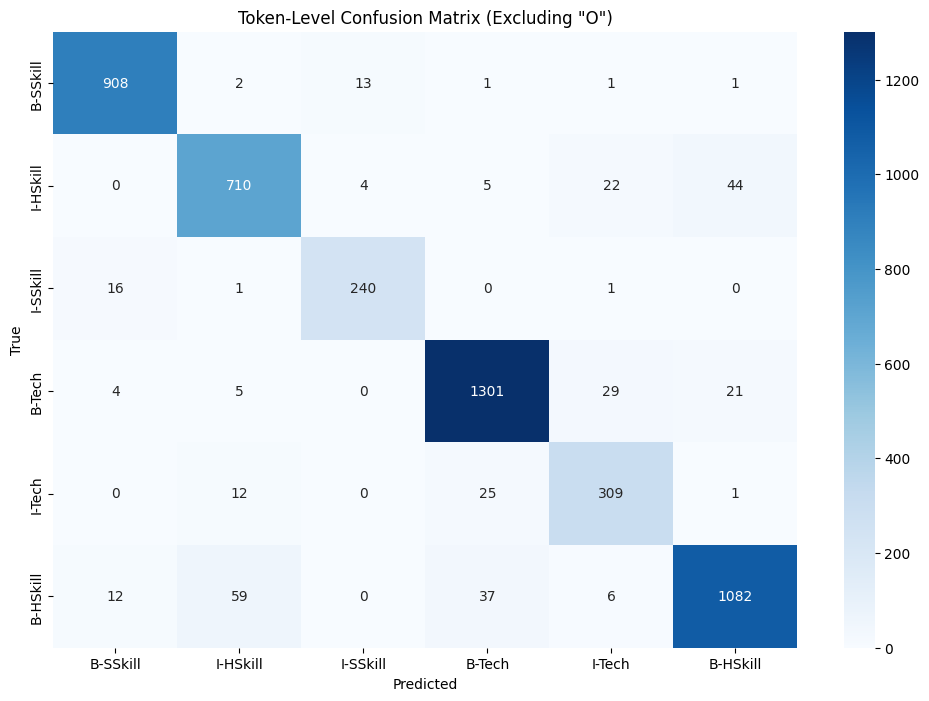

In [ ]:
# Flatten true and predicted labels
y_test_flat = [label for sent in y_test for label in sent]
y_pred_flat = [label for sent in y_test_pred for label in sent]

# Get unique tags and filter out 'O' if desired
tags = list(set(y_test_flat + y_pred_flat))
if 'O' in tags:
    tags.remove('O')  # Optional: exclude 'O' for clarity

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=tags)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tags, yticklabels=tags)
plt.title('Token-Level Confusion Matrix (Excluding "O")')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

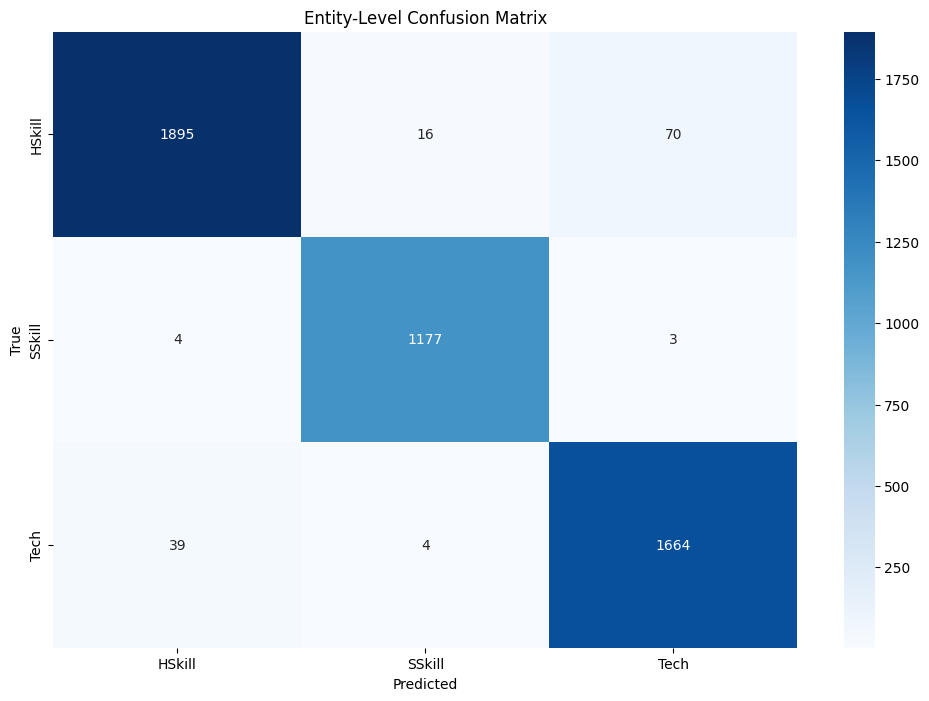

In [ ]:
from seqeval.metrics import classification_report

# Create a custom function to compute the entity-level confusion matrix
def compute_entity_confusion_matrix(y_true, y_pred, labels):
    """
    Computes the confusion matrix for entity-level classification.

    Parameters:
    - y_true: List of lists with true labels.
    - y_pred: List of lists with predicted labels.
    - labels: List of unique entity labels.

    Returns:
    - confusion_matrix: 2D numpy array representing the confusion matrix.
    """
    import numpy as np

    label_to_index = {label: i for i, label in enumerate(labels)}
    confusion_matrix = np.zeros((len(labels), len(labels)), dtype=int)

    for true_sent, pred_sent in zip(y_true, y_pred):
        for true_tag, pred_tag in zip(true_sent, pred_sent):
            if true_tag != 'O' and pred_tag != 'O':  # Ignore 'O' tags (no entity)
                true_entity = true_tag.split('-')[1]
                pred_entity = pred_tag.split('-')[1]
                if true_entity in labels and pred_entity in labels:
                    true_idx = label_to_index[true_entity]
                    pred_idx = label_to_index[pred_entity]
                    confusion_matrix[true_idx, pred_idx] += 1
    return confusion_matrix

# Example labels (replace with actual entities from your data)
entity_labels = list(set([tag.split('-')[1] for sent in y_test for tag in sent if tag != 'O']))

entity_cm = compute_entity_confusion_matrix(y_test, y_test_pred, labels=entity_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(entity_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=entity_labels, yticklabels=entity_labels)
plt.title('Entity-Level Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



=== Correctly Predicted Entities (Top 20) ===
Word         True      Predicted
PHP          B-Tech    B-Tech       89
komunikasi   B-SSkill  B-SSkill     64
tim          B-SSkill  B-SSkill     57
HTML         B-Tech    B-Tech       54
pemrograman  B-HSkill  B-HSkill     52
CSS          B-Tech    B-Tech       45
jaringan     B-HSkill  B-HSkill     44
perangkat    B-HSkill  B-HSkill     43
Java         B-Tech    B-Tech       41
MySQL        B-Tech    B-Tech       40
lunak        I-HSkill  I-HSkill     40
Inggris      I-SSkill  I-SSkill     37
Software     B-HSkill  B-HSkill     34
software     B-HSkill  B-HSkill     34
SQL          B-HSkill  B-HSkill     33
database     B-HSkill  B-HSkill     32
individu     B-SSkill  B-SSkill     32
Linux        B-Tech    B-Tech       31
tekanan      I-SSkill  I-SSkill     31
Microsoft    B-Tech    B-Tech       30
Name: count, dtype: int64

=== Incorrectly Predicted Entities (Top 20) ===
Word          True      Predicted
IT            B-HSkill  O      

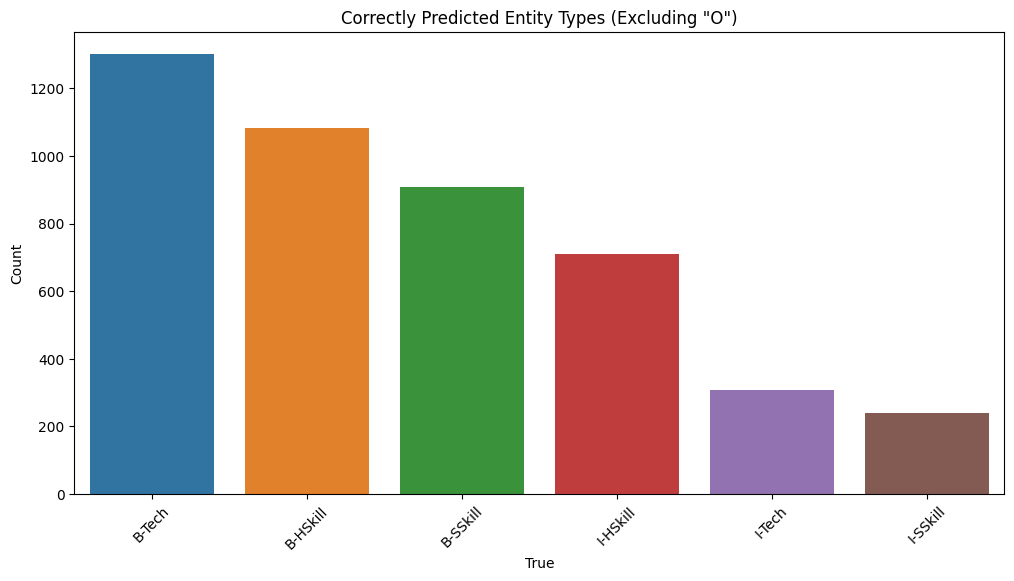

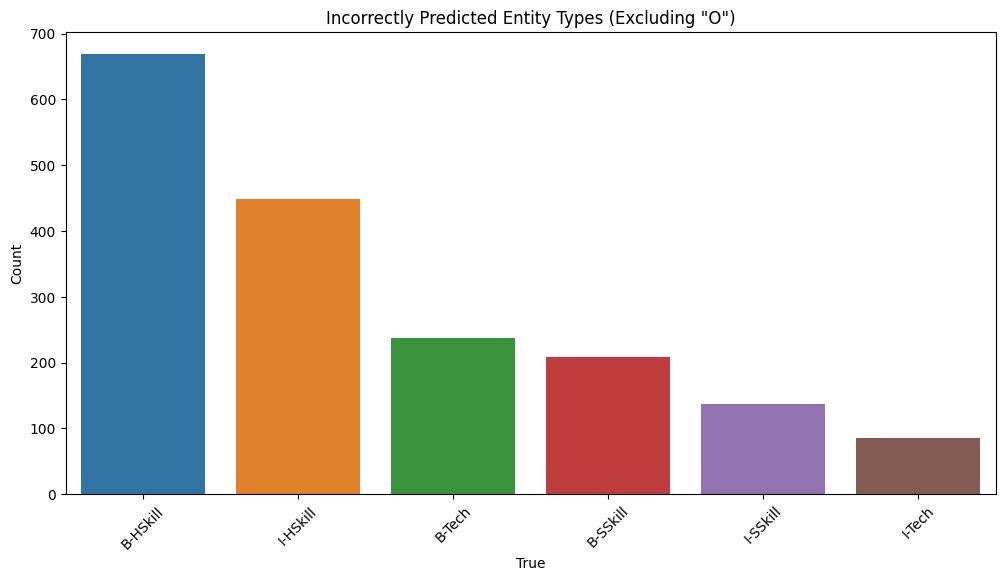


=== Examples of Errors ===
Word: 'Android' | True: B-Tech | Predicted: I-HSkill
Word: 'Pemrograman' | True: B-HSkill | Predicted: O
Word: '#' | True: I-Tech | Predicted: O
Word: 'multi-tugas-' | True: B-SSkill | Predicted: O
Word: 'TI' | True: B-HSkill | Predicted: O
Word: 'Menginstal' | True: B-HSkill | Predicted: O
Word: 'mengkonfigurasi' | True: B-HSkill | Predicted: O
Word: 'perangkat' | True: I-HSkill | Predicted: B-HSkill
Word: 'TI' | True: B-HSkill | Predicted: O
Word: 'troubleshooting' | True: B-HSkill | Predicted: I-HSkill


In [ ]:
# Function to compare predictions vs true labels
def compare_predictions(sentences, true_labels, pred_labels):
    correct = []
    incorrect = []

    for sent, true, pred in zip(sentences, true_labels, pred_labels):
        for (word, _), t, p in zip(sent, true, pred):
            if t == 'O' and p == 'O':
                continue  # Skip 'O' tags

            if t == p:
                correct.append((word, t, p))
            else:
                incorrect.append((word, t, p))

    return correct, incorrect

# Get comparison results
correct_preds, incorrect_preds = compare_predictions(
    test_sentences, y_test, y_test_pred
)

# Convert to DataFrames for better visualization
correct_df = pd.DataFrame(correct_preds, columns=['Word', 'True', 'Predicted'])
incorrect_df = pd.DataFrame(incorrect_preds, columns=['Word', 'True', 'Predicted'])

# Analysis of correct predictions (excluding 'O')
print("\n=== Correctly Predicted Entities (Top 20) ===")
print(correct_df[correct_df['True'] != 'O'].value_counts().head(20))

# Analysis of incorrect predictions (excluding 'O')
print("\n=== Incorrectly Predicted Entities (Top 20) ===")
print(incorrect_df[incorrect_df['True'] != 'O'].value_counts().head(20))

# Visualization of correct predictions
plt.figure(figsize=(12, 6))
correct_counts = correct_df[correct_df['True'] != 'O']['True'].value_counts()
sns.barplot(x=correct_counts.index, y=correct_counts.values)
plt.title('Correctly Predicted Entity Types (Excluding "O")')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# Visualization of incorrect predictions
plt.figure(figsize=(12, 6))
incorrect_counts = incorrect_df[incorrect_df['True'] != 'O']['True'].value_counts()
sns.barplot(x=incorrect_counts.index, y=incorrect_counts.values)
plt.title('Incorrectly Predicted Entity Types (Excluding "O")')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# Detailed examples of errors
print("\n=== Examples of Errors ===")
for i, (word, true, pred) in enumerate(incorrect_df[incorrect_df['True'] != 'O'].itertuples(index=False)):
    if i >= 10:  # Show first 10 examples
        break
    print(f"Word: '{word}' | True: {true} | Predicted: {pred}")


=== Entity-Level Prediction Analysis ===
Correctly predicted entities: 3145
Incorrectly predicted entities: 2107
Partial matches (right span, wrong type): 56

Top 20 Correctly Predicted Entities:
PHP [Tech] (44-44)                    5
pemrograman [HSkill] (51-51)          4
CSS [Tech] (48-48)                    4
PHP [Tech] (26-26)                    4
MySQL [Tech] (44-44)                  4
Java [Tech] (42-42)                   3
bertanggung jawab [SSkill] (39-40)    3
komunikasi [SSkill] (71-71)           3
Database [HSkill] (50-50)             3
PHP [Tech] (69-69)                    3
HTML [Tech] (37-37)                   3
perangkat lunak [HSkill] (38-39)      3
CSS [Tech] (41-41)                    3
PHP [Tech] (54-54)                    3
CSS [Tech] (59-59)                    3
PHP [Tech] (65-65)                    3
JavaScript [Tech] (57-57)             3
komunikasi [SSkill] (54-54)           3
pemrograman [HSkill] (54-54)          3
pemrograman [HSkill] (34-34)          3
Nam

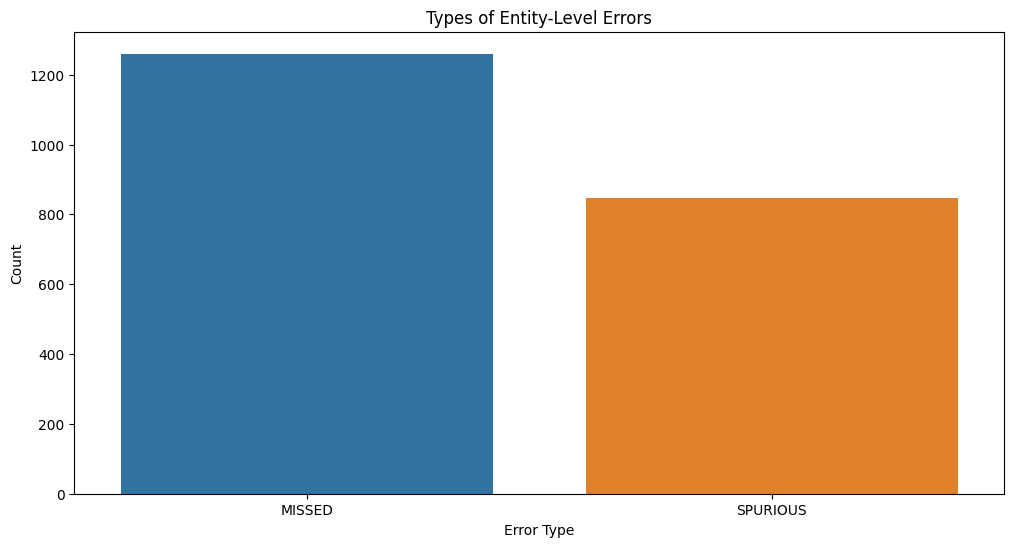

In [ ]:
from seqeval.metrics import classification_report
from collections import defaultdict

# Function to extract entities from BIO tags
def extract_entities(bio_tags, words):
    entities = []
    current_entity = None

    for i, (tag, word) in enumerate(zip(bio_tags, words)):
        if tag.startswith('B-'):
            if current_entity is not None:
                entities.append(current_entity)
            current_entity = {'type': tag[2:], 'start': i, 'end': i, 'text': [word]}
        elif tag.startswith('I-'):
            if current_entity is not None and tag[2:] == current_entity['type']:
                current_entity['end'] = i
                current_entity['text'].append(word)
        else:
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None

    if current_entity is not None:
        entities.append(current_entity)

    # Convert entity info to string format "text [type] (start-end)"
    return [f"{' '.join(e['text'])} [{e['type']}] ({e['start']}-{e['end']})" for e in entities]

# Collect all entity-level comparisons
correct_entities = []
incorrect_entities = []
partial_matches = defaultdict(int)

for sent, true_tags, pred_tags in zip(test_sentences, y_test, y_test_pred):
    words = [word for word, _ in sent]
    true_entities = extract_entities(true_tags, words)
    pred_entities = extract_entities(pred_tags, words)

    # Check for exact matches
    matched = set()
    for t_ent in true_entities:
        if t_ent in pred_entities:
            correct_entities.append(t_ent)
            matched.add(t_ent)
        else:
            # Check for partial matches (same span but wrong type)
            t_text = t_ent.split(' [')[0]
            t_span = t_ent.split('(')[1].split(')')[0]

            for p_ent in pred_entities:
                p_text = p_ent.split(' [')[0]
                p_span = p_ent.split('(')[1].split(')')[0]

                if t_text == p_text and t_span == p_span and p_ent not in matched:
                    partial_matches[(t_ent, p_ent)] += 1
                    matched.add(p_ent)
                    break

    # Find completely missed entities
    for t_ent in true_entities:
        if t_ent not in matched:
            incorrect_entities.append((t_ent, "MISSED"))

    # Find spurious entities
    for p_ent in pred_entities:
        if p_ent not in matched and not any(p_ent.split(' [')[0] == t.split(' [')[0]
                                          for t in true_entities):
            incorrect_entities.append((p_ent, "SPURIOUS"))

# Analysis
print("\n=== Entity-Level Prediction Analysis ===")
print(f"Correctly predicted entities: {len(correct_entities)}")
print(f"Incorrectly predicted entities: {len(incorrect_entities)}")
print(f"Partial matches (right span, wrong type): {sum(partial_matches.values())}")

# Show most common correct entities
print("\nTop 20 Correctly Predicted Entities:")
correct_counts = pd.Series(correct_entities).value_counts().head(20)
print(correct_counts)

# Show most common errors
print("\nTop 20 Error Types:")
error_df = pd.DataFrame(incorrect_entities, columns=['Entity', 'Error Type'])
error_counts = error_df.groupby(['Entity', 'Error Type']).size().sort_values(ascending=False).head(20)
print(error_counts)

# Show partial matches
print("\nTop 20 Partial Matches (Right Span, Wrong Type):")
print(pd.Series(partial_matches).sort_values(ascending=False).head(20))

# Visualization
plt.figure(figsize=(12, 6))
error_types = error_df['Error Type'].value_counts()
sns.barplot(x=error_types.index, y=error_types.values)
plt.title('Types of Entity-Level Errors')
plt.ylabel('Count')
plt.show()